In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim

def wsd_schedule(
    n_iterations,
    final_lr_factor=0.0,
    n_warmup=1000,
    init_div_factor=100,
    fract_decay=0.1,
    decay_type="linear",
):
    """Warmup, hold, and decay schedule.
    Args:
        n_iterations: total number of iterations
        final_lr_factor: factor by which to reduce max_lr at the end
        n_warmup: number of warmup iterations
        init_div_factor: initial division factor for warmup
        fract_decay: fraction of iterations used for decay
        decay_type: type of decay ("linear", "exp", "cosine", ...)
    Returns:
        schedule: a function that takes the current iteration and
        returns the multiplicative factor for the learning rate
    """
    n_anneal_steps = int(fract_decay * n_iterations)
    n_hold = n_iterations - n_anneal_steps

    def schedule(step):
        if step < n_warmup:
            # Warmup from lr/init_div_factor to lr
            return (step / n_warmup) + (1 - step / n_warmup) / init_div_factor
        elif step < n_hold:
            # Hold at lr
            return 1.0
        elif step < n_iterations:
            # Decay phase
            if decay_type == "linear":
                return final_lr_factor + (1 - final_lr_factor) * (
                    1 - (step - n_hold) / n_anneal_steps
                )
            elif decay_type == "exp":
                return final_lr_factor ** ((step - n_hold) / n_anneal_steps)
            elif decay_type == "cosine":
                return (
                    final_lr_factor
                    + (1 - final_lr_factor)
                    * (1 + math.cos(math.pi * (step - n_hold) / n_anneal_steps))
                    * 0.5
                )
            elif decay_type == "miror_cosine":
                cosine_value = (
                    final_lr_factor
                    + (1 - final_lr_factor)
                    * (1 + math.cos(math.pi * (step - n_hold) / n_anneal_steps))
                    * 0.5
                )
                linear_value = final_lr_factor + (1 - final_lr_factor) * (
                    1 - (step - n_hold) / n_anneal_steps
                )
                return linear_value * 2 - cosine_value
            elif decay_type == "square":
                return final_lr_factor + (1 - final_lr_factor) * (
                    1 - ((step - n_hold) / n_anneal_steps) ** 2
                )
            elif decay_type == "sqrt":
                return final_lr_factor + (1 - final_lr_factor) * (
                    1 - math.sqrt((step - n_hold) / n_anneal_steps)
                )
            else:
                raise ValueError(
                    f"decay type {decay_type} is not supported."
                )
        else:
            return final_lr_factor

    return schedule


In [11]:
import torch
import torch.optim as optim

# 定义一个简单的参数类
class Args:
    def __init__(self, lr, iterations, warmup_steps, scheduler, div_factor, final_div_factor):
        self.lr = lr
        self.iterations = iterations
        self.warmup_steps = warmup_steps
        self.scheduler = scheduler
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor

# 第一个参数集：总长度15000 steps
args_15000 = Args(
    lr=1.0,
    iterations=15000,
    warmup_steps=1500,
    scheduler="cos",  # 可选: "cos" or "linear"
    div_factor=1e2,
    final_div_factor=0.1
)

# 第二个参数集：总长度30000 steps
args_30000 = Args(
    lr=1.0,
    iterations=30000,
    warmup_steps=1500,
    scheduler="cos",  # 可选: "cos" or "linear"
    div_factor=1e2,
    final_div_factor=0.1
)

def get_onecycle_lr_list(args):
    # 简单模型，仅用于演示
    model = torch.nn.Linear(10, 1)  
    optimizer = optim.SGD(model.parameters(), lr=args.lr)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=[args.lr],  # 单个参数组
        total_steps=args.iterations,
        pct_start=args.warmup_steps / args.iterations, 
        anneal_strategy=args.scheduler,  # "cos"或"linear"
        cycle_momentum=False,
        div_factor=args.div_factor,
        final_div_factor=args.final_div_factor,
    )

    max_lr = args.lr
    onecycle_lrs = []
    for step in range(args.iterations):
        current_lr = optimizer.param_groups[0]['lr']
        onecycle_lrs.append(current_lr / max_lr)
        scheduler.step()
    return onecycle_lrs

# 获取两个不同长度的 lr schedule 列表
onecycle_lrs_15000 = get_onecycle_lr_list(args_15000)
onecycle_lrs_30000 = get_onecycle_lr_list(args_30000)

# 现在您有两个列表：onecycle_lrs_15000 和 onecycle_lrs_30000
print("Length of onecycle_lrs_15000:", len(onecycle_lrs_15000))
print("Length of onecycle_lrs_30000:", len(onecycle_lrs_30000))

Length of onecycle_lrs_15000: 15000
Length of onecycle_lrs_30000: 30000


/mntcephfs/lab_data/chenyupeng/conda_files/envs/gpt/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


In [3]:
# # 模拟参数
# class Args:
#     lr = 1.0
#     iterations = 15000
#     warmup_steps = 1500
#     scheduler = "cos"  # 可选: "cos" or "linear"
#     div_factor = 1e2
#     final_div_factor = 0.1
    
# args = Args()

# # 准备优化器和 OneCycleLR 调度器
# model = torch.nn.Linear(10, 1)  # 简单模型，仅用于演示
# optimizer = optim.SGD(model.parameters(), lr=args.lr)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer=optimizer,
#     max_lr=[args.lr],  # 单个参数组
#     total_steps=args.iterations,
#     pct_start=args.warmup_steps / args.iterations, 
#     anneal_strategy=args.scheduler,  # "cos"或"linear"
#     cycle_momentum=False,
#     div_factor=args.div_factor,
#     final_div_factor=args.final_div_factor,
# )

# # 获取 OneCycleLR (cos) 下每个 step 的 lr factor
# # 对于 OneCycleLR，初始lr是 max_lr/div_factor，
# # 因此lr factor相对于 max_lr 来说是 current_lr/max_lr
# max_lr = args.lr
# onecycle_lrs = []
# for step in range(args.iterations):
#     current_lr = optimizer.param_groups[0]['lr']
#     onecycle_lrs.append(current_lr / max_lr)
#     scheduler.step()


In [6]:
# 对比 WSD 与 OneCycleLR (cos)
# 尝试使 WSD 参数与 OneCycleLR 的初始和结束比例相匹配
# OneCycleLR 的 warmup 为 pct_start=0.1，即 warmup_steps=1000，占总长度的10%
# anneal_strategy='cos'：剩下的90%为cosine衰减

# 对于WSD，设定:
# fract_decay = 0.9，意味着有90%的时间用于衰减(与OneCycleLR一致)
# init_div_factor=100，与OneCycleLR匹配
# final_lr_factor=? 
# OneCycleLR的最终lr = initial_lr/final_div_factor
# initial_lr = max_lr/div_factor = 1/100 = 0.01
# final_lr = initial_lr/final_div_factor = 0.01/0.1 = 0.1
# final_lr相对于max_lr=1.0来说是0.1
# 因此 final_lr_factor = 0.1

wsd_linear_schedule = wsd_schedule(
    n_iterations=15000,
    final_lr_factor=0.0,
    n_warmup=args_15000.warmup_steps,
    init_div_factor=int(args_15000.div_factor),
    fract_decay=0.2,
    decay_type="linear",
)

wsd_linear_vals = [wsd_linear_schedule(s) for s in range(15000)]

In [13]:
wsd_linear_schedule_30000 = wsd_schedule(
    n_iterations=30000,
    final_lr_factor=0.0,
    n_warmup=args_30000.warmup_steps,
    init_div_factor=int(args_30000.div_factor),
    fract_decay=0.2,
    decay_type="linear",
)

wsd_linear_vals_30000 = [wsd_linear_schedule_30000(s) for s in range(30000)]

In [ ]:
### 只画wsd的

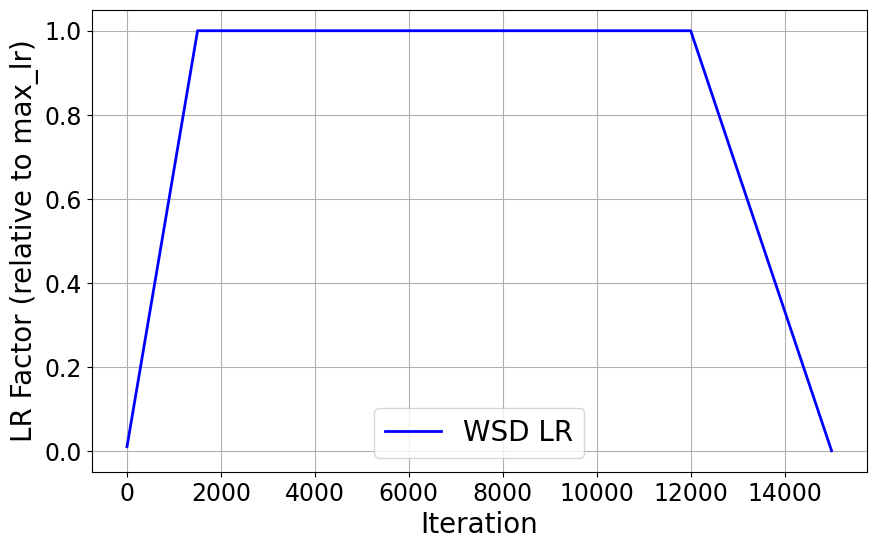

In [9]:

plt.rcParams['axes.labelsize'] = 17
plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 17

# 绘图对比
plt.figure(figsize=(10, 6))
plt.plot(range(15000), wsd_linear_vals, label="WSD LR", linewidth=2, color='blue', linestyle='-')
# plt.plot(range(30000), wsd_linear_vals_30000, linewidth=2, color='blue', linestyle='--')
# plt.plot(range(15000), onecycle_lrs_15000, label="Cosine LR", linewidth=2, color='orange', linestyle='-')
# plt.plot(range(30000), onecycle_lrs_30000, linewidth=2, color='orange', linestyle='--')
# plt.title("WSD and Cosine Learning Rate Schedule")
plt.xlabel("Iteration", fontsize=20)
plt.ylabel("LR Factor (relative to max_lr)", fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)

plt.savefig('/home/chenyupeng/yupeng/jaggi-lr/wandb2csv/plots/only_wsd.pdf')


plt.show()

In [ ]:
### 只画cosine的

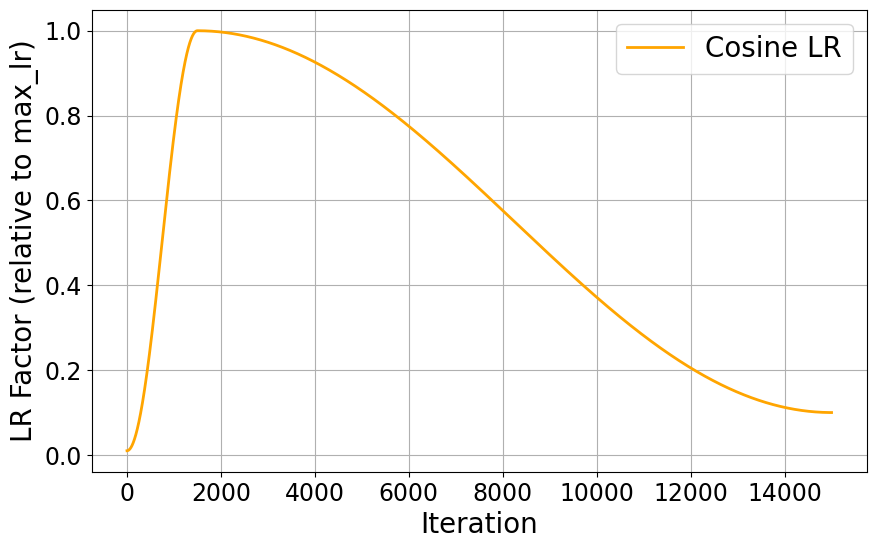

In [10]:

plt.rcParams['axes.labelsize'] = 17
plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 17

# 绘图对比
plt.figure(figsize=(10, 6))
# plt.plot(range(15000), wsd_linear_vals, label="WSD LR", linewidth=2, color='blue', linestyle='-')
# plt.plot(range(30000), wsd_linear_vals_30000, linewidth=2, color='blue', linestyle='--')
plt.plot(range(15000), onecycle_lrs_15000, label="Cosine LR", linewidth=2, color='orange', linestyle='-')
# plt.plot(range(30000), onecycle_lrs_30000, linewidth=2, color='orange', linestyle='--')
# plt.title("WSD and Cosine Learning Rate Schedule")
plt.xlabel("Iteration", fontsize=20)
plt.ylabel("LR Factor (relative to max_lr)", fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)

plt.savefig('/home/chenyupeng/yupeng/jaggi-lr/wandb2csv/plots/only_cosine.pdf')


plt.show()

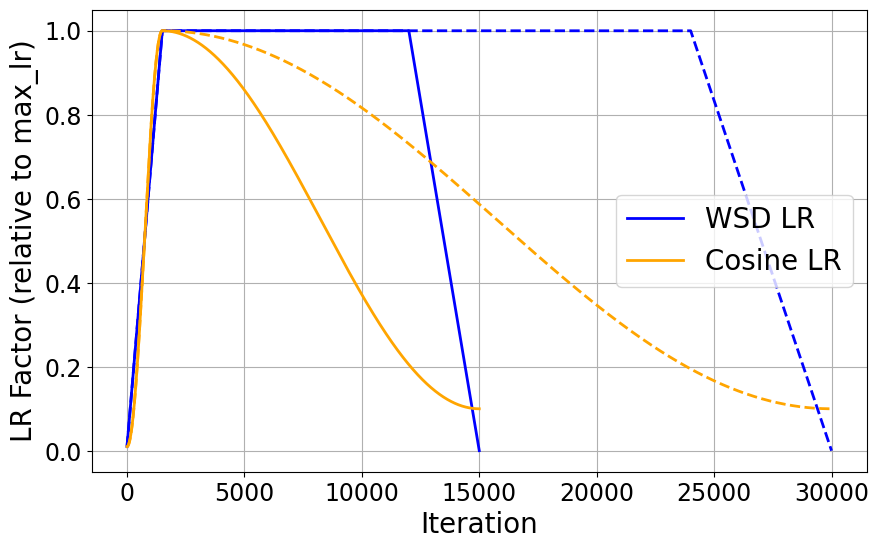

In [14]:

plt.rcParams['axes.labelsize'] = 17
plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 17

# 绘图对比
plt.figure(figsize=(10, 6))
plt.plot(range(15000), wsd_linear_vals, label="WSD LR", linewidth=2, color='blue', linestyle='-')
plt.plot(range(30000), wsd_linear_vals_30000, linewidth=2, color='blue', linestyle='--')
# plt.plot(range(args.iterations), onecycle_lrs, label="OneCycleLR Linear", linewidth=2, linestyle='--')
plt.plot(range(15000), onecycle_lrs_15000, label="Cosine LR", linewidth=2, color='orange', linestyle='-')
plt.plot(range(30000), onecycle_lrs_30000, linewidth=2, color='orange', linestyle='--')
# plt.title("WSD and Cosine Learning Rate Schedule")
plt.xlabel("Iteration", fontsize=20)
plt.ylabel("LR Factor (relative to max_lr)", fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)

plt.savefig('/home/chenyupeng/yupeng/jaggi-lr/wandb2csv/plots/wsdVScosine.pdf')


plt.show()

In [2]:
## i want to know what is linear lr for onecycle


import torch
import torch.optim as optim

# 定义一个简单的参数类
class Args:
    def __init__(self, lr, iterations, warmup_steps, scheduler, div_factor, final_div_factor):
        self.lr = lr
        self.iterations = iterations
        self.warmup_steps = warmup_steps
        self.scheduler = scheduler
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor

# 第一个参数集：总长度15000 steps
args_15000_linear = Args(
    lr=1.0,
    iterations=15000,
    warmup_steps=1500,
    scheduler="linear",  # 可选: "cos" or "linear"
    div_factor=1e2,
    final_div_factor=0.1
)

def get_onecycle_lr_list(args):
    # 简单模型，仅用于演示
    model = torch.nn.Linear(10, 1)  
    optimizer = optim.SGD(model.parameters(), lr=args.lr)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=[args.lr],  # 单个参数组
        total_steps=args.iterations,
        pct_start=args.warmup_steps / args.iterations, 
        anneal_strategy=args.scheduler,  # "cos"或"linear"
        cycle_momentum=False,
        div_factor=args.div_factor,
        final_div_factor=args.final_div_factor,
    )

    max_lr = args.lr
    onecycle_lrs = []
    for step in range(args.iterations):
        current_lr = optimizer.param_groups[0]['lr']
        onecycle_lrs.append(current_lr / max_lr)
        scheduler.step()
    return onecycle_lrs

# 获取两个不同长度的 lr schedule 列表
onecycle_lrs_linear = get_onecycle_lr_list(args_15000_linear)

# 现在您有两个列表：onecycle_lrs_15000 和 onecycle_lrs_30000
print("Length of onecycle_lrs_15000_linear:", len(onecycle_lrs_linear))

Length of onecycle_lrs_15000_linear: 15000


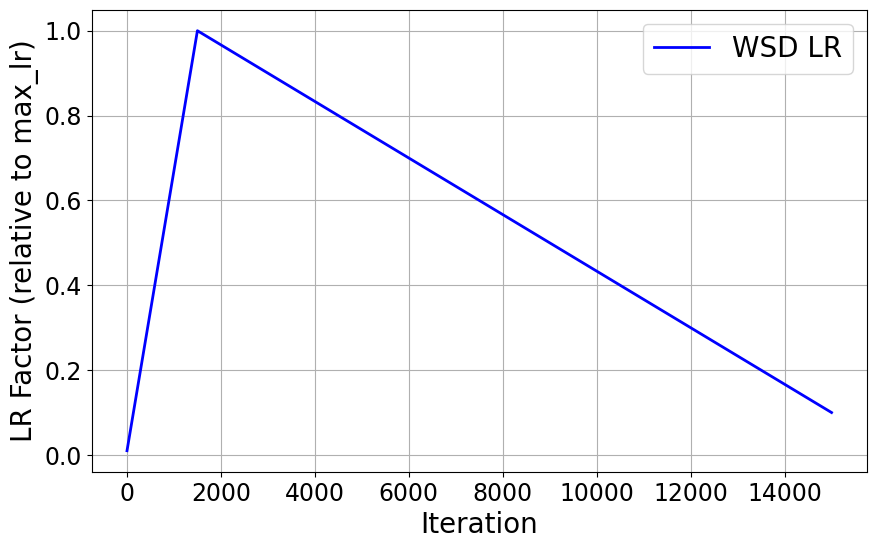

In [4]:

import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim

plt.rcParams['axes.labelsize'] = 17
plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 17

# 绘图对比
plt.figure(figsize=(10, 6))
plt.plot(range(15000), onecycle_lrs_linear, label="WSD LR", linewidth=2, color='blue', linestyle='-')
# plt.plot(range(30000), wsd_linear_vals_30000, linewidth=2, color='blue', linestyle='--')
plt.xlabel("Iteration", fontsize=20)
plt.ylabel("LR Factor (relative to max_lr)", fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)

# plt.savefig('/home/chenyupeng/yupeng/jaggi-lr/wandb2csv/plots/wsdVScosine.pdf')


plt.show()

In [20]:
wsd_linear_schedule_no = wsd_schedule(
    n_iterations=args.iterations,
    final_lr_factor=0.0,
    n_warmup=0,
    init_div_factor=int(args.div_factor),
    fract_decay=0.0,
    decay_type="linear",
)

wsd_no_vals = [wsd_linear_schedule_no(s) for s in range(args.iterations)]

wsd_linear_schedule_only_cooldown = wsd_schedule(
    n_iterations=args.iterations,
    final_lr_factor=0.0,
    n_warmup=0,
    init_div_factor=int(args.div_factor),
    fract_decay=0.1,
    decay_type="linear",
)

wsd_only_cooldown_vals = [wsd_linear_schedule_only_cooldown(s) for s in range(args.iterations)]

wsd_linear_schedule_only_warmup = wsd_schedule(
    n_iterations=args.iterations,
    final_lr_factor=0.0,
    n_warmup=1500,
    init_div_factor=int(args.div_factor),
    fract_decay=0.1,
    decay_type="linear",
)

wsd_only_warmup_vals = [wsd_linear_schedule_only_warmup(s) for s in range(args.iterations)]

wsd_linear_schedule_full = wsd_schedule(
    n_iterations=args.iterations,
    final_lr_factor=0.0,
    n_warmup=1500,
    init_div_factor=int(args.div_factor),
    fract_decay=0.1,
    decay_type="linear",
)

wsd_full_vals = [wsd_linear_schedule_full(s) for s in range(args.iterations)]

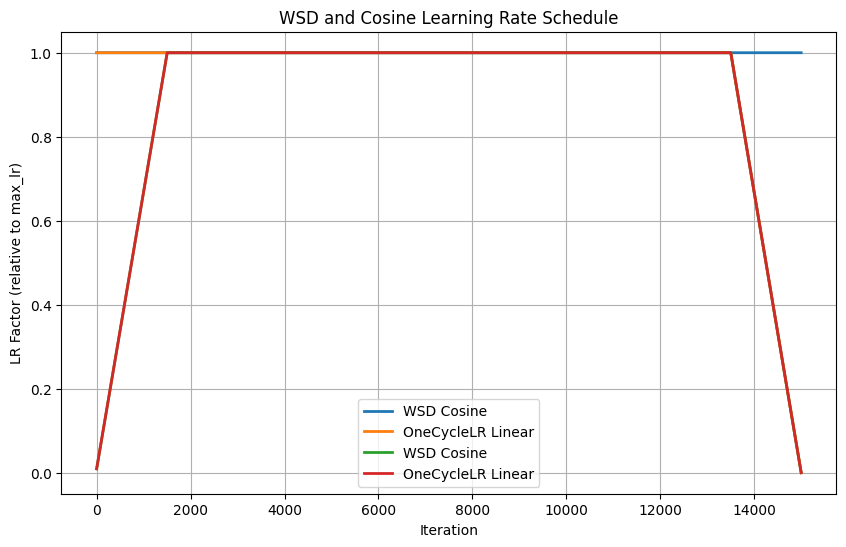

In [21]:
# 绘图对比
plt.figure(figsize=(10, 6))
plt.plot(range(args.iterations), wsd_no_vals, label="WSD Cosine", linewidth=2)
plt.plot(range(args.iterations), wsd_only_cooldown_vals, label="OneCycleLR Linear", linewidth=2)
plt.plot(range(args.iterations), wsd_only_warmup_vals, label="WSD Cosine", linewidth=2)
plt.plot(range(args.iterations), wsd_full_vals, label="OneCycleLR Linear", linewidth=2)
plt.title("WSD and Cosine Learning Rate Schedule")
plt.xlabel("Iteration")
plt.ylabel("LR Factor (relative to max_lr)")
plt.grid(True)
plt.legend()

plt.savefig('/home/chenyupeng/yupeng/jaggi-lr/wandb2csv/plots/ablation_cooldownAndwarmup.pdf')


plt.show()